In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [2]:
telecom = pd.read_csv("train_data.csv")
telecom.head()

,CustomerID,Surname,NetworkScore,Region,Gender,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,IsActiveMember,EstimatedMonthlyUsage,Exited
0,4971,Moreno,25.0,South,Female,26.0,11,134.20,1,0,1.0,NaN,1
1,2858,Bell,68.0,North,Female,60.0,17,25.72,3,1,1.0,533.40,0
2,5794,Baker,34.0,North,Male,28.0,7,131.03,2,0,0.0,509.04,0
3,3996,Jackson,13.0,South,Male,65.0,2,64.27,3,0,1.0,246.48,0
4,2680,Craig,50.0,East,Female,60.0,16,41.26,3,1,1.0,902.28,1


In [3]:
telecom.shape

(4020, 13)

In [4]:
telecom.describe()

,CustomerID,NetworkScore,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,IsActiveMember,EstimatedMonthlyUsage,Exited
count,4020.000000,3821.000000,3812.000000,4020.000000,4020.000000,4020.000000,4020.000000,3822.000000,3823.000000,4020.000000
mean,2985.333333,51.172468,43.961962,10.092786,109.808458,2.479104,0.507463,0.490581,548.373380,0.485572
std,1729.892759,28.975876,15.300416,6.076202,52.417745,1.122198,0.500006,0.499977,258.494824,0.499854
min,3.000000,1.000000,18.000000,0.000000,20.030000,1.000000,0.000000,0.000000,100.090000,0.000000
25%,1481.750000,26.000000,31.000000,5.000000,64.652500,1.000000,0.000000,0.000000,329.485000,0.000000
50%,2981.500000,52.000000,44.000000,10.000000,109.335000,2.000000,1.000000,0.000000,546.250000,0.000000
75%,4467.500000,77.000000,57.000000,15.000000,155.782500,3.000000,1.000000,1.000000,772.725000,1.000000
max,6000.000000,100.000000,70.000000,20.000000,199.960000,4.000000,1.000000,1.000000,999.820000,1.000000


In [5]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             4020 non-null   int64  
 1   Surname                4020 non-null   object 
 2   NetworkScore           3821 non-null   float64
 3   Region                 4020 non-null   object 
 4   Gender                 4020 non-null   object 
 5   Age                    3812 non-null   float64
 6   Tenure                 4020 non-null   int64  
 7   MonthlyCharge          4020 non-null   float64
 8   NumOfProducts          4020 non-null   int64  
 9   HasInternetService     4020 non-null   int64  
 10  IsActiveMember         3822 non-null   float64
 11  EstimatedMonthlyUsage  3823 non-null   float64
 12  Exited                 4020 non-null   int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 408.4+ KB


In [6]:
#dropping irrelevant columns
telecom.drop(['CustomerID','Surname'],axis=1, inplace=True)
telecom.head()

,NetworkScore,Region,Gender,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,IsActiveMember,EstimatedMonthlyUsage,Exited
0,25.0,South,Female,26.0,11,134.20,1,0,1.0,NaN,1
1,68.0,North,Female,60.0,17,25.72,3,1,1.0,533.40,0
2,34.0,North,Male,28.0,7,131.03,2,0,0.0,509.04,0
3,13.0,South,Male,65.0,2,64.27,3,0,1.0,246.48,0
4,50.0,East,Female,60.0,16,41.26,3,1,1.0,902.28,1


In [7]:
#checking for missing values
telecom.isnull().sum()

NetworkScore             199
Region                     0
Gender                     0
Age                      208
Tenure                     0
MonthlyCharge              0
NumOfProducts              0
HasInternetService         0
IsActiveMember           198
EstimatedMonthlyUsage    197
Exited                     0
dtype: int64

In [8]:
# Checking the percentage of missing values
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

NetworkScore             4.95
Region                   0.00
Gender                   0.00
Age                      5.17
Tenure                   0.00
MonthlyCharge            0.00
NumOfProducts            0.00
HasInternetService       0.00
IsActiveMember           4.93
EstimatedMonthlyUsage    4.90
Exited                   0.00
dtype: float64

In [9]:
# drop rows which contains null values, as we have plenty of rows for model building
telecom.dropna(inplace=True)
telecom.drop(['IsActiveMember'],axis=1,inplace=True)
#show shape now to identify how many columns are dropped. after dropping we still have plenty of rows to build model
telecom.shape

(3282, 10)

In [10]:
#create dummy variables for categorical variables
telecom = pd.concat([telecom,pd.get_dummies(telecom[['Region', 'Gender']], drop_first=True).astype(int)], axis=1)
telecom.drop(['Region', 'Gender'],axis=1, inplace=True)
telecom.head()

,NetworkScore,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,EstimatedMonthlyUsage,Exited,Region_North,Region_South,Region_West,Gender_Male,Gender_Other
1,68.0,60.0,17,25.72,3,1,533.40,0,1,0,0,0,0
2,34.0,28.0,7,131.03,2,0,509.04,0,1,0,0,1,0
3,13.0,65.0,2,64.27,3,0,246.48,0,0,1,0,1,0
4,50.0,60.0,16,41.26,3,1,902.28,1,0,0,0,0,0
5,18.0,63.0,5,99.55,4,0,949.95,0,1,0,0,0,0


In [11]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3282 entries, 1 to 4019
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NetworkScore           3282 non-null   float64
 1   Age                    3282 non-null   float64
 2   Tenure                 3282 non-null   int64  
 3   MonthlyCharge          3282 non-null   float64
 4   NumOfProducts          3282 non-null   int64  
 5   HasInternetService     3282 non-null   int64  
 6   EstimatedMonthlyUsage  3282 non-null   float64
 7   Exited                 3282 non-null   int64  
 8   Region_North           3282 non-null   int32  
 9   Region_South           3282 non-null   int32  
 10  Region_West            3282 non-null   int32  
 11  Gender_Male            3282 non-null   int32  
 12  Gender_Other           3282 non-null   int32  
dtypes: float64(4), int32(5), int64(4)
memory usage: 294.9 KB


### Checking for Outliers

In [12]:
telecom[['NetworkScore','Age','Tenure','MonthlyCharge','NumOfProducts','EstimatedMonthlyUsage']].describe(percentiles=[.25, .5, .75, .90, .95, .99])

,NetworkScore,Age,Tenure,MonthlyCharge,NumOfProducts,EstimatedMonthlyUsage
count,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000,3282.000000
mean,51.249238,44.158745,10.058806,109.892639,2.463132,550.785442
std,28.946704,15.249348,6.043065,52.231583,1.117869,257.535548
min,1.000000,18.000000,0.000000,20.030000,1.000000,100.090000
25%,26.000000,31.000000,5.000000,65.147500,1.000000,332.635000
50%,53.000000,44.000000,10.000000,109.335000,2.000000,551.085000
75%,77.000000,57.000000,15.000000,155.585000,3.000000,774.660000
90%,91.000000,65.000000,18.000000,182.450000,4.000000,906.968000
95%,95.950000,68.000000,19.000000,190.240000,4.000000,954.212000
99%,99.000000,70.000000,20.000000,198.239000,4.000000,990.578800


From the distribution shown above, you can see that there no outliers in your data. The numbers are gradually increasing.

### Feature Scaling

In [13]:
scaler = MinMaxScaler()
num_vars = ['NetworkScore', 'Age',"Tenure",'MonthlyCharge','NumOfProducts','EstimatedMonthlyUsage']
telecom[num_vars]=scaler.fit_transform(telecom[num_vars])
telecom.describe().T

,count,mean,std,min,25%,50%,75%,max
NetworkScore,3282.0,0.507568,0.292391,0.0,0.252525,0.525253,0.767677,1.0
Age,3282.0,0.503053,0.293257,0.0,0.250000,0.500000,0.750000,1.0
Tenure,3282.0,0.502940,0.302153,0.0,0.250000,0.500000,0.750000,1.0
MonthlyCharge,3282.0,0.499431,0.290288,0.0,0.250750,0.496332,0.753376,1.0
NumOfProducts,3282.0,0.487711,0.372623,0.0,0.000000,0.333333,0.666667,1.0
HasInternetService,3282.0,0.513102,0.499904,0.0,0.000000,1.000000,1.000000,1.0
EstimatedMonthlyUsage,3282.0,0.500923,0.286236,0.0,0.258461,0.501256,0.749747,1.0
Exited,3282.0,0.487812,0.499928,0.0,0.000000,0.000000,1.000000,1.0
Region_North,3282.0,0.255637,0.436285,0.0,0.000000,0.000000,1.000000,1.0
Region_South,3282.0,0.250457,0.433342,0.0,0.000000,0.000000,1.000000,1.0


### Looking at Correlations

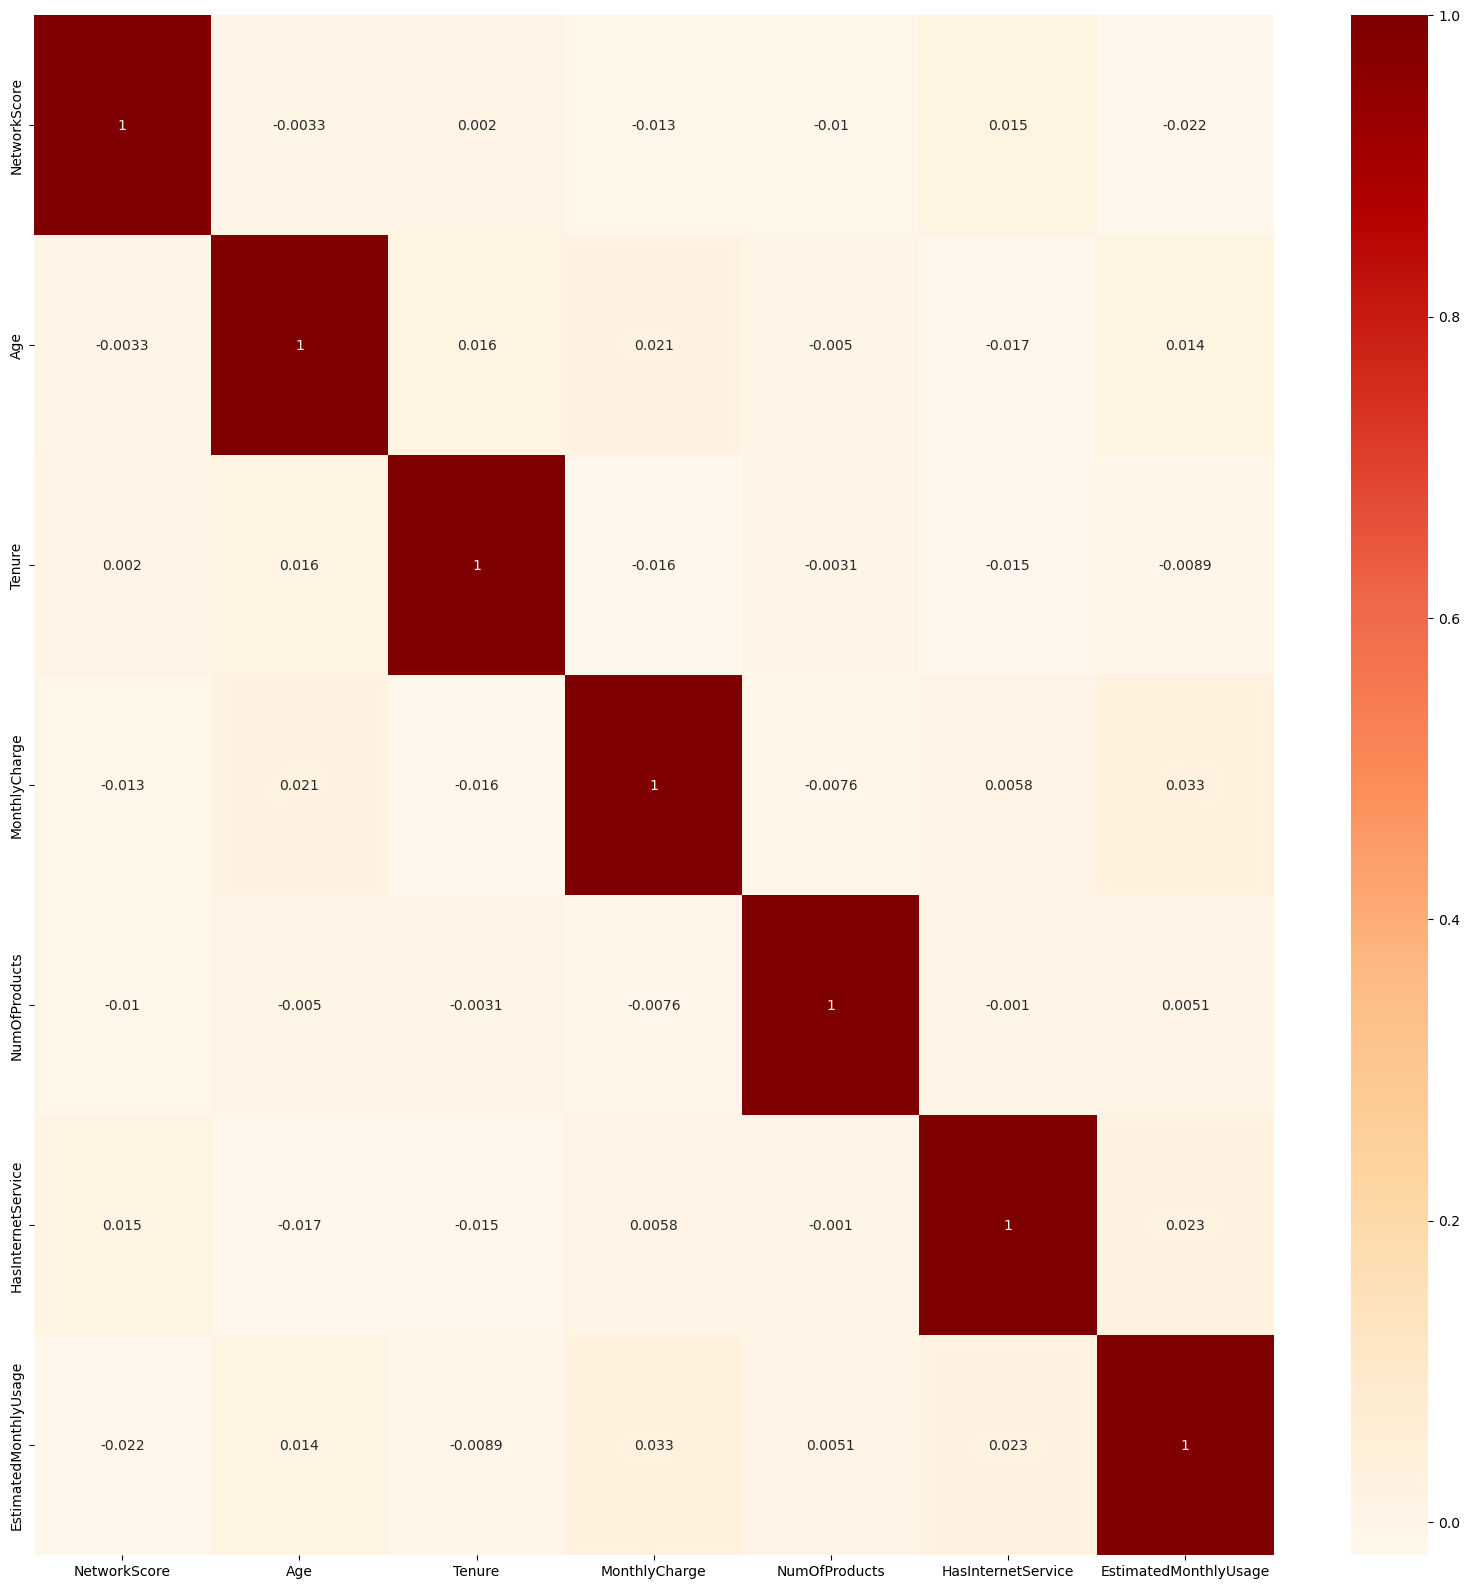

In [14]:
#heatmap to show the correlation between variables
plt.figure(figsize = (20,20))
sns.heatmap(telecom[['NetworkScore','Age','Tenure','MonthlyCharge','NumOfProducts','HasInternetService','EstimatedMonthlyUsage']].corr(),cmap='OrRd',annot =True)
plt.show()

here, we can there is approx no correlation between variables, therefore we can goahead and build model.

In [15]:
### Checking the Churn Rate
churn = (sum(telecom['Exited'])/len(telecom['Exited'].index))*100
churn

48.7812309567337

we have aprox 49% churn rate.

### Train test split

In [16]:
X = telecom.drop(['Exited'], axis=1)
y = telecom['Exited']
# X_train, X_test, y_train, y_test split to build model and test on the dataset, after good build we will predict on test dataset which give in different file.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

### Using Decision Trees (Default parameters)

In [17]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [18]:
y_pred = dt.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.6270928462709284


above accuracy scrore is 64%, lets try with hyper-parameter tuning

### Hyper-parameter tuning for the Decision Tree (Tuned Hyperparameters)

In [27]:
params = {
    "max_depth": [2,3,4,5,7],
    "min_samples_leaf": [30,40,50,80],
    "criterion": ['gini','entropy']
}

dt_hyp = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt_hyp,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, 
                           verbose=1, 
                           scoring="accuracy")

In [28]:
%%time
grid_search.fit(X_train, y_train)
grid_search.best_score_

Fitting 4 folds for each of 40 candidates, totalling 160 fits
CPU times: total: 578 ms
Wall time: 2.62 s


0.7561874698370271

In [29]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, random_state=42)

In [30]:
y_pred = dt_best.predict(X_test)
dt_best_acc = accuracy_score(y_pred, y_test)
dt_best_acc

0.7625570776255708

after hyper-parameter tunning, we can observe the accuracy is increased to 77%.

### Using Random Forest (Default parameters)

In [31]:
rf = RandomForestClassifier(n_estimators=10, oob_score=True)
rf.fit(X_train, y_train)
rf.oob_score_

0.6628571428571428

#### Hyper-parameter tuning for the Random Forest (Tuned Hyperparameters)

In [40]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [3,4,5],
    'min_samples_leaf': [35,40,50],
    'n_estimators': [5,6,7],
    'max_features': [8,11,13,15]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, 
                           verbose=1, 
                           scoring="accuracy")

In [41]:
%%time
grid_search.fit(X_train, y_train)
grid_search.best_score_

Fitting 4 folds for each of 108 candidates, totalling 432 fits
CPU times: total: 2.41 s
Wall time: 30.2 s


0.7565685673980027

In [42]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=4, max_features=13, min_samples_leaf=40,
                       n_estimators=6, n_jobs=-1, random_state=42)

In [43]:
y_pred = rf_best.predict(X_test)
rf_best_acc = accuracy_score(y_pred, y_test)
rf_best_acc

0.756468797564688

accuracy is approx 76%

### Using XGBoost

In [44]:
xgb_cl = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic')
xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict(X_test)
accuracy_score(y_pred, y_test)

0.680365296803653

### Hyper-parameter tuning for XGBoost (Tuned Hyperparameters)

In [45]:
param_grid = {
    'learning_rate': [0.02,0.03,0.04],
    'n_estimators': [80,90,100],
    'max_depth': [3,4,5],
    'min_child_weight': [0.3,0.4,0.5],
    'gamma': [0.1,0.2],
    'subsample': [0.4,0.5,0.6],
    'colsample_bytree': [0.5,0.7,0.8],
    'reg_alpha': [ 0.1,0.3, 0.5],
    'reg_lambda': [0.0, 0.1]
}

xgb_cl_hyp = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic')
random_search = RandomizedSearchCV(estimator=xgb_cl_hyp, param_distributions=param_grid, 
                                   n_iter=50, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_params

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'subsample': 0.6,
 'reg_lambda': 0.1,
 'reg_alpha': 0.3,
 'n_estimators': 80,
 'min_child_weight': 0.5,
 'max_depth': 3,
 'learning_rate': 0.03,
 'gamma': 0.2,
 'colsample_bytree': 0.8}

In [46]:
random_search.best_score_

0.7546666666666668

In [47]:
xgb_cl_best = random_search.best_estimator_
y_pred = xgb_cl_best.predict(X_test)
xgb_best_acc = accuracy_score(y_pred, y_test)
xgb_best_acc

0.76103500761035

xgboosting give us accuracy of approx 76%.

### Plotting all results

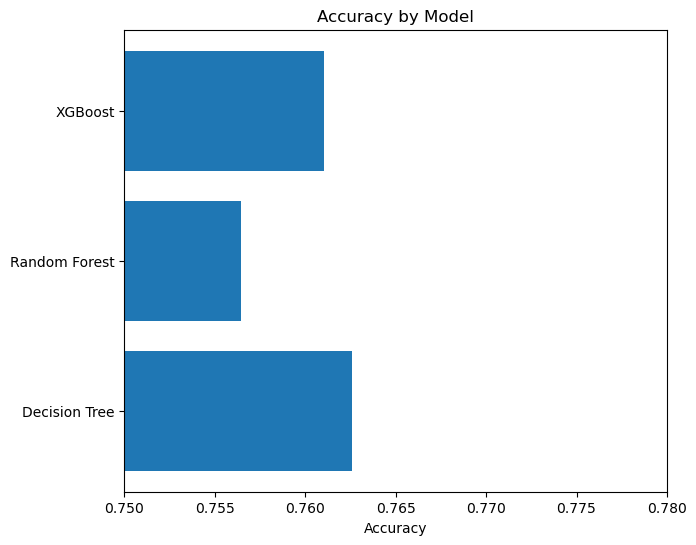

In [48]:
plt.figure(figsize=(7, 6))

plt.barh(['Decision Tree','Random Forest', 'XGBoost'], [dt_best_acc,rf_best_acc,xgb_best_acc])
plt.xlim(0.75, 0.78)
plt.xlabel('Accuracy')
plt.title('Accuracy by Model')

plt.show()

All models are performing approximatly same, however Decision tree performed best with 76.2% accuracy

## Using Random Forest (hyper tunned) to predict value of test dataset

In [49]:
#performing all feature cleanup which was performed during model building
telecom_test = pd.read_csv("test_data.csv")
tel_df =telecom_test.drop(['CustomerID','Surname'],axis=1)
tel_df.isnull().sum()

NetworkScore              101
Region                      0
Gender                      0
Age                        92
Tenure                      0
MonthlyCharge               0
NumOfProducts               0
HasInternetService          0
IsActiveMember            102
EstimatedMonthlyUsage     103
Exited                   1980
dtype: int64

treating null values (we can not drop rows, as we need to predict for all)

In [50]:
tel_df['NetworkScore'].fillna(tel_df['NetworkScore'].mean(), inplace=True)
tel_df['Age'].fillna(tel_df['Age'].mean(), inplace=True)
tel_df['EstimatedMonthlyUsage'].fillna(tel_df['EstimatedMonthlyUsage'].mean(), inplace=True)
tel_df.drop(['IsActiveMember'],axis=1,inplace=True)
tel_df.head()

,NetworkScore,Region,Gender,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,EstimatedMonthlyUsage,Exited
0,31.000000,South,Other,24.0,10,141.98,3,1,543.230000,NaN
1,34.000000,East,Other,22.0,19,40.45,3,1,537.918151,NaN
2,85.000000,East,Other,48.0,20,54.95,3,0,312.020000,NaN
3,50.031932,South,Female,69.0,4,97.21,1,1,537.918151,NaN
4,27.000000,West,Male,59.0,10,101.76,2,1,864.170000,NaN


In [51]:
tel_df.isnull().sum()

NetworkScore                0
Region                      0
Gender                      0
Age                         0
Tenure                      0
MonthlyCharge               0
NumOfProducts               0
HasInternetService          0
EstimatedMonthlyUsage       0
Exited                   1980
dtype: int64

In [52]:
tel_df = pd.concat([tel_df,pd.get_dummies(tel_df[['Region', 'Gender']], drop_first=True).astype(int)], axis=1)
tel_df.drop(['Region', 'Gender'],axis=1, inplace=True)
tel_df.head()

,NetworkScore,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,EstimatedMonthlyUsage,Exited,Region_North,Region_South,Region_West,Gender_Male,Gender_Other
0,31.000000,24.0,10,141.98,3,1,543.230000,NaN,0,1,0,0,1
1,34.000000,22.0,19,40.45,3,1,537.918151,NaN,0,0,0,0,1
2,85.000000,48.0,20,54.95,3,0,312.020000,NaN,0,0,0,0,1
3,50.031932,69.0,4,97.21,1,1,537.918151,NaN,0,1,0,0,0
4,27.000000,59.0,10,101.76,2,1,864.170000,NaN,0,0,1,1,0


In [53]:
scaler = MinMaxScaler()
num_vars = ['NetworkScore', 'Age',"Tenure",'MonthlyCharge','NumOfProducts','EstimatedMonthlyUsage']
tel_df[num_vars]=scaler.fit_transform(tel_df[num_vars])
tel_df.describe().T

,count,mean,std,min,25%,50%,75%,max
NetworkScore,1980.0,0.495272,0.280828,0.0,0.272727,0.495272,0.737374,1.0
Age,1980.0,0.493746,0.288557,0.0,0.250000,0.493746,0.730769,1.0
Tenure,1980.0,0.492197,0.300040,0.0,0.250000,0.500000,0.750000,1.0
MonthlyCharge,1980.0,0.497933,0.285108,0.0,0.255980,0.489487,0.744966,1.0
NumOfProducts,1980.0,0.492088,0.372839,0.0,0.000000,0.333333,0.666667,1.0
HasInternetService,1980.0,0.494444,0.500095,0.0,0.000000,0.000000,1.000000,1.0
EstimatedMonthlyUsage,1980.0,0.486210,0.282315,0.0,0.243798,0.486210,0.727661,1.0
Exited,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region_North,1980.0,0.242929,0.428961,0.0,0.000000,0.000000,0.000000,1.0
Region_South,1980.0,0.244444,0.429866,0.0,0.000000,0.000000,0.000000,1.0


In [54]:
X_test = tel_df.drop(['Exited'],axis=1)
X_test.head()

,NetworkScore,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,EstimatedMonthlyUsage,Region_North,Region_South,Region_West,Gender_Male,Gender_Other
0,0.303030,0.115385,0.50,0.677940,0.666667,1,0.492116,0,1,0,0,1
1,0.333333,0.076923,0.95,0.113194,0.666667,1,0.486210,0,0,0,0,1
2,0.848485,0.576923,1.00,0.193848,0.666667,0,0.235028,0,0,0,0,1
3,0.495272,0.980769,0.20,0.428913,0.000000,1,0.486210,0,1,0,0,0
4,0.262626,0.788462,0.50,0.454222,0.333333,1,0.848978,0,0,1,1,0


In [55]:
y_pred = dt_best.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [56]:
summary = pd.read_csv("sample_submission.csv")
summary['Exited']=y_pred

In [57]:
summary.to_csv('sample_submission.csv', index=False)